In [2]:
import json
import gensim
import pandas as pd
import numpy as np
import nltk
nltk.download('popular')
from nltk.stem import WordNetLemmatizer

with open('data/full_format_recipes.json') as f:
  data = json.load(f)

data = pd.DataFrame.from_dict(data, orient='columns')
data.shape

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/hex-3/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/hex-3/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/hex-3/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/hex-3/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/hex-3/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /home/hex-3/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!

(20130, 11)

In [3]:
### drop rows with no ingredients list and no recipes
data.dropna(axis = 0, subset = ['ingredients', 'directions'], inplace = True)
data.shape

(20111, 11)

In [4]:
idx = np.random.rand(len(data)) < 0.8

train_data = data.iloc[idx]
validation_data = data.iloc[~idx]

print(len(train_data), len(validation_data))

16108 4003


In [0]:
### common measures used
measures= np.array(['liter','millilitres','mL','grams','g', 'kg','teaspoon',
          'tsp', 'tablespoon','tbsp','fluid', 'ounce','oz','fl.oz', 'cup','pint','pt',
          'quart','qt','gallon','gal','smidgen','drop','pinch','dash','scruple',
          'dessertspoon','teacup','cup','c','pottle','gill','dram','wineglass','coffeespoon',
          'pound','pounded','lb','tbsp','plus','firmly', 'packed','lightly','level','even',
          'rounded','heaping','heaped','sifted','bushel','peck','stick','chopped','sliced',
          'halves', 'shredded','slivered','sliced','whole','paste','whole',' fresh', 'peeled', 
          'diced','mashed','dried','frozen','fresh','peeled','candied','no', 'pulp','crystallized',
          'canned','crushed','minced','julienned','clove','head', 'small','large','medium', 'torn', 'cleaned', 'degree'])

lemmatizer = WordNetLemmatizer()
measures = np.array([lemmatizer.lemmatize(m) for m in measures])

In [0]:
### make a list of ingredients present in the given recipes

meal_ingredients = []

for ingredient in train_data['ingredients']:
    for ingr in ingredient:
      simp_ingr = ""
      tokens = nltk.word_tokenize(ingr.strip())
      tokens = [token for token in tokens if token.isalpha()]
      tokens = [lemmatizer.lemmatize(token) for token in tokens]
      tokens = [token for token in tokens if token not in measures]
      pos_tokens = nltk.pos_tag(tokens)
      for tok, tag in pos_tokens:
          if tag.startswith("N"):
              simp_ingr += tok.lower() + " "
      simp_ingr = simp_ingr[:-1]
      if simp_ingr:
        meal_ingredients.append(simp_ingr)

In [7]:
print(meal_ingredients[:50])

['stock', 'brown lentil', 'lentil', 'stalk celery', 'carrot', 'sprig thyme', 'kosher salt', 'tomato', 'fuji apple', 'lemon juice', 'oil', 'ground pepper', 'sheet cut crosswise flour tortilla', 'turkey breast', 'bibb lettuce', 'cream', 'onion', 'salt', 'bay leaf', 'garlic', 'pepper', 'ground nutmeg', 'pinch thyme', 'shallot', 'butter', 'boneless center pork sinew cut chunk', 'egg', 'flour', 'tawny port', 'currant', 'lettuce leaf', 'peppercorn', 'minced parsley', 'bay leaf', 'bread baguette slice', 'oil', 'onion', 'currant', 'wine vinegar', 'chicken broth', 'thyme', 'sugar', 'fennel bulb anise stalk bulb cut dice feathery leaf garnish', 'onion', 'butter', 'russet baking potato', 'chicken broth', 'milk', 'oil', 'onion']


In [8]:
### Bag of Words Model

model = gensim.models.Word2Vec(min_count = 1,  
                              size = 100, window = 5) 
model.build_vocab(meal_ingredients)
model.train(meal_ingredients, total_examples = model.corpus_count, 
            epochs=100, report_delay=1)

(29382097, 169443700)

In [9]:
## vectors for all the words

X = model[model.wv.vocab]

X.shape

### Why does it get so reduced???

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(49, 100)

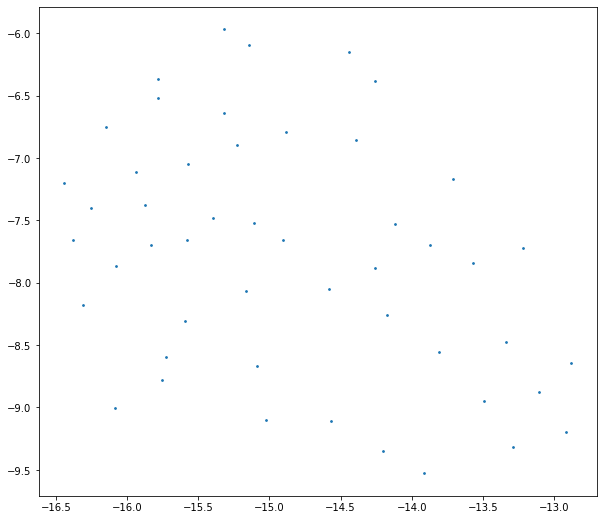

In [11]:
import umap
import matplotlib.pyplot as plt

##### Visualisation
##### The ingredients do not cluster!!

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [16]:
model.most_similar(positive=['apple'], topn= 5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


KeyError: ignored

In [4]:
import json
import csv

import numpy as np
import random

def query(params):

    cart = [data[int(idx)] for idx in params['cart']]
    allergys = [a for a in params['allergys']]
    pantry = [p for p in params['pantry']]

    # Candidate Generator
    def candidate_generator(num_generated_candidates):
        # Vectorize cart: Dictionaries { ingredient : count }
        cart_ingredients = np.zeros(len(data[0]['ingredient_vector']))
        for recipe in cart:
            cart_ingredients = np.maximum(cart_ingredients, recipe['ingredient_vector'])

        # Returns true if the recipe does not conflict with the user's allergy restrictions
        def allergy_checker(recipe):
            allergy_categories = {
                'dairy': ['dairy', 'milk', 'cheese', 'butter', 'yogurt', 'cream'],
                'nuts': ['nut', 'almond', 'cashew', 'pecan'],
                'shellfish': ['shellfish', 'clam', 'oyster', 'mussel', 'scallop'],
                'gluten': ['gluten', 'wheat', 'rye', 'barley', 'bread', 'pasta', 'beer', 'bread']
            }

            # If finds allergy, return false
            for allergy in allergys: # for evert allergy,
                if allergy in allergy_categories: # if it's in one of our saved allergy categories
                    allergy_words = allergy_categories[allergy] # get all the words for that allergy category
                    for ingredient in recipe['ingredients']: # for every ingredient
                        for allergy_word in allergy_words: # check if any allergy words are in the ingredient
                            if allergy_word in ingredient: # if they are, allergy check fails.
                                return False
            
            # If no allergy issue, return true (passed allergy check)
            return True   

        # Containment of vector a in b
        def containment(a, b):
            within = np.dot(a, b)
            total = np.sum(a)
            if total == 0:
                return 0
            return within / total

        # IOU of vectors a and b
        def iou(a, b):
            intersection = np.sum(np.dot(a, b))
            union = np.sum(a) + np.sum(b) - intersection
            if union == 0:
                return 0
            return intersection / union

        # Find similar recipes by ingredients, querying our similarity method
        candidate_ranks = []
        for other_recipe in data:
            if allergy_checker(other_recipe): # Only consider a recipe for candidacy if it doesn't violate the user's allergy restrictions
                other_ingredients = other_recipe['ingredient_vector']
                rank = containment(other_ingredients, cart_ingredients)
                candidate_ranks.append((rank, other_recipe))

        # Candidates have been generated, by sorting by most similar
        generated_candidates = [x[1] for x in sorted(candidate_ranks, reverse=True, key=lambda x: x[0])][:num_generated_candidates]
        return generated_candidates

    # Ranker
    def ranker(generated_candidates, num_ranked_results):
        
        # Helper method to generate random subset of candidates
        def sample_random_subset_of_candidates(generated_candidates, num_ranked_results):
            sample_subset = random.sample(generated_candidates, num_ranked_results)
            return sample_subset

        # Nutrition similarity
        def nutrition_similarity(candidate_nutrition, other_candidate_nutrition):
            
            def iou(a, b):
                intersection = np.sum(np.dot(a, b))
                union = np.sum(a) + np.sum(b) - intersection
                if union == 0:
                    return 0
                return intersection / union
            
            nutrition_vector = list(candidate_nutrition.values())
            other_nutrition_vector = list(other_candidate_nutrition.values())

            similarity = iou(nutrition_vector, other_nutrition_vector)
            
            return similarity
        
        # Generate many random subsets of candidates, and measure the nutrition diversity in each
        num_sample_subsets = 50
        sample_subsets_and_their_nutrition_diversity_scores = []
        for i in range(num_sample_subsets):
            sample_subset = sample_random_subset_of_candidates(generated_candidates, num_ranked_results)

            # For each pair of candidates in the subset, measure the similarity.
            subset_nutrition_similarities = []
            for candidate in sample_subset:
                for otherCandidate in sample_subset:
                    if candidate['id'] != otherCandidate['id']:
                        # Compare every candidate with every other candidate
                        candidate_nutrition = {
                            'fat': candidate['fat'],
                            'protein': candidate['protein'],
                            'sodium': candidate['sodium'],
                            'calories': candidate['calories']
                        }

                        other_candidate_nutrition = {
                            'fat': otherCandidate['fat'],
                            'protein': otherCandidate['protein'],
                            'sodium': otherCandidate['sodium'],
                            'calories': otherCandidate['calories']
                        }

                        # Check for missing nutrient information, don't include in average
                        if None not in list(candidate_nutrition.values()) and None not in list(other_candidate_nutrition.values()):
                            nutrition_sim = nutrition_similarity(candidate_nutrition, other_candidate_nutrition)
                            subset_nutrition_similarities.append(nutrition_sim)

            # Average the similarity across pairs of candidates to get a measure of how similar the cluster is to itself
            average_inter_subset_nutrition_similarity = sum(subset_nutrition_similarities) / len(subset_nutrition_similarities)

            # Diversity score is the opposite of average similarity
            nutrition_diversity_score = -1 * average_inter_subset_nutrition_similarity # Diversity is negative similarity

            # Record the diversity score for each randomly generated subset
            sample_subsets_and_their_nutrition_diversity_scores.append((sample_subset, nutrition_diversity_score))

        # Pick the subset with the highest nutrition diversity
        most_nutrition_diverse_subset = [subset_score_pair[0] for subset_score_pair in sorted(sample_subsets_and_their_nutrition_diversity_scores, key=lambda x: -x[1], reverse=False)][0]

        # Sort resulting items by rating
        ranked_results = sorted(most_nutrition_diverse_subset, key=lambda x: -x['rating'])

        return ranked_results
    
    num_generated_candidates = 100
    num_ranked_results = 20

    generated_candidates = candidate_generator(num_generated_candidates)
    final_results = ranker(generated_candidates, num_ranked_results)

    return final_results



In [5]:
data = None
with open('data/full_format_recipes_plus_normalized_ingredients.json') as f:
    data = json.load(f)
for i, recipe in enumerate(data):
    recipe['id'] = i


In [20]:
len(data)

100

In [41]:
def get_recs(args):  
    fields = ['cart', 'allergys', 'pantry']
    list_separator = ';;;'
    
    recommendation_params = {}
    
    for field in fields:
        if field in args:
            recommendation_params[field] = args[field].split(list_separator)

    recs = query(recommendation_params)

    return recs

diff_r = []
args = [{'cart': '12', 'allergys': 'shellfish', 'pantry': 'carrots'},
        {'cart': '10', 'allergys': 'dairy', 'pantry': 'potatoes'},
        {'cart': '10', 'allergys': 'gluten', 'pantry': ''},
        {'cart': '96', 'allergys': '', 'pantry': 'carrots'},
        {'cart': '45', 'allergys': 'nut', 'pantry': ''}]

for i in range(5):
    diff_r.append(get_recs(args[i]))

In [45]:
x = []
for user in diff_r:
    x.append(user[0]['ingredient_vector'])
x = np.array(x)
from sklearn.metrics.pairwise import cosine_similarity
sim = cosine_similarity(x)
sim

array([[1.        , 0.1490712 , 0.28005602, 0.21821789, 0.18257419],
       [0.1490712 , 1.        , 0.06262243, 0.09759001, 0.08164966],
       [0.28005602, 0.06262243, 1.        , 0.09166985, 0.153393  ],
       [0.21821789, 0.09759001, 0.09166985, 1.        , 0.23904572],
       [0.18257419, 0.08164966, 0.153393  , 0.23904572, 1.        ]])

In [46]:
np.sum([1.        , 0.1490712 , 0.28005602, 0.21821789, 0.18257419, 1.        , 0.06262243, 0.09759001, 0.08164966, 1.        , 0.09166985, 0.153393  , 1.        , 0.23904572, 1])

6.55588997

In [47]:
6.55588997-5

1.55588997

In [48]:
1.55588997/5

0.311177994

In [32]:
diff_r = np.array(diff_r)
user = {}
recipes_ret= set()
for i in range(5):
    for rec in (diff_r[i]) : ## iterate over all recipes for one user
        print(rec.keys())
        #recipes_ret.add(rec['title'])

print(len(recipes_ret))

dict_keys(['directions', 'fat', 'date', 'categories', 'calories', 'desc', 'protein', 'rating', 'title', 'ingredients', 'sodium', 'ingredient_names', 'parsed_ingredients', 'ingredient_vector', 'id'])
dict_keys(['directions', 'fat', 'date', 'categories', 'calories', 'desc', 'protein', 'rating', 'title', 'ingredients', 'sodium', 'ingredient_names', 'parsed_ingredients', 'ingredient_vector', 'id'])
dict_keys(['directions', 'fat', 'date', 'categories', 'calories', 'desc', 'protein', 'rating', 'title', 'ingredients', 'sodium', 'ingredient_names', 'parsed_ingredients', 'ingredient_vector', 'id'])
dict_keys(['directions', 'fat', 'date', 'categories', 'calories', 'desc', 'protein', 'rating', 'title', 'ingredients', 'sodium', 'ingredient_names', 'parsed_ingredients', 'ingredient_vector', 'id'])
dict_keys(['directions', 'fat', 'date', 'categories', 'calories', 'desc', 'protein', 'rating', 'title', 'ingredients', 'sodium', 'ingredient_names', 'parsed_ingredients', 'ingredient_vector', 'id'])
dict_

In [35]:
s = []
for ls in x:
    #print(ls['ingredient_vector'])
    s.append(ls['ingredient_vector'])
s = np.array(s)
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(s)
similarities.shape

(20, 20)